N= 249
k= 0 ------------------------------
0 XX 0.72839504 0.73333335
update layer
update layer
10
update layer
update layer
20
update layer
update layer
update layer
30
40
accuracy: 0.73333335 0.73333335
k= 1 ------------------------------
0 XX 0.72839504 0.73333335
update layer
update layer
10
update layer
update layer
20
update layer
update layer
update layer
30 XX 0.7327758 0.76666665
40 XX 0.7395363 0.76666665
accuracy: 0.76666665 0.76666665
k= 2 ------------------------------
0 XX 0.72839504 0.6333333
update layer
update layer
10
update layer
update layer
20
update layer
update layer
update layer
30
40
accuracy: 0.6333333 0.76666665
k= 3 ------------------------------
0 XX 0.34567901 0.26666668
update layer
update layer
10 XX 0.56565654 0.73333335
update layer
update layer
20 XX 0.60787773 0.73333335
update layer
update layer
update layer
30 XX 0.62405413 0.8
40 XX 0.63444746 0.8
accuracy: 0.8 0.76666665
k= 4 ------------------------------
0 XX 0.28395063 0.26666668
update layer


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x0000028354F61840>
Traceback (most recent call last):
  File "C:\Users\KL\Anaconda3\lib\site-packages\tensorflow_core\python\data\ops\iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "C:\Users\KL\Anaconda3\lib\site-packages\tensorflow_core\python\ops\gen_dataset_ops.py", line 1158, in delete_iterator
    deleter)
KeyboardInterrupt: 


update layer
update layer
30 XX 0.67980886 0.8
40 XX 0.6919603 0.8
accuracy: 0.8 0.73333335
final accuracy: 0.73333335


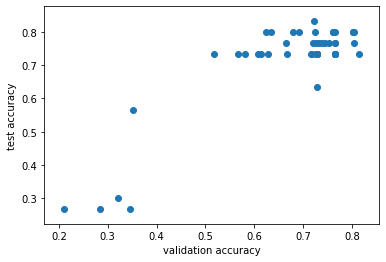

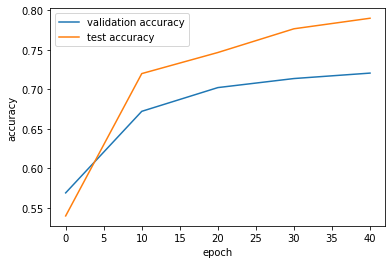

In [13]:
# hybrid model DLS my proposal

# P 05
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.activations import relu
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import make_blobs
import numpy as np
import random 


#import statistics 
from scipy.stats import ks_2samp

#tf.enable_eager_execution()


class LSLayer(tf.keras.layers.Layer):
    
    def __init__(self,  num_outputs_s, num_outputs_r, num_outputs_l, indata,  Ara = 1.0, activation=sigmoid, wstd = 0.3, bstd = 0.5):
        super(LSLayer, self).__init__()
        self.num_outputs_l = num_outputs_l
        self.num_outputs_s = num_outputs_s 
        self.num_outputs_r = num_outputs_r
        self.num_outputs = num_outputs_l + num_outputs_s + num_outputs_r
        self.activation = activation
        self.wstd = wstd
        self.bstd = bstd
        self.traindata = indata
        self.Ara = Ara
        
    def build(self, input_shape):  
        self.num_inputs = input_shape[-1]
        self.kernel = self.add_weight("kernel",
                                      shape=(int(input_shape[-1]),
                                             self.num_outputs), 
                                      initializer=tf.keras.initializers.RandomNormal(stddev=self.wstd),
                                     trainable=True)

        self.bias = self.add_weight("bias",
                                      shape=[self.num_outputs],
                                    initializer=tf.keras.initializers.RandomNormal(stddev=self.bstd),
                                   trainable=True)
            
        #print ( "set_circles ---------------------------")
        
        M = self.num_outputs_s + self.num_outputs_r
        
        if M == 0:
            return
        
        x_train =  self.traindata[0]
        y_train =  self.traindata[1]
        N = x_train.shape[0]   
        D = x_train.shape[1]   
        C = min (M*10,int(0.3*N))
        #print ("C",C,"M",M)
        
        cls = KMeans(n_clusters=C).fit(x_train)
        
        centers = cls.cluster_centers_
        #print ("centers", centers.shape)
        #print (centers)
        labels = cls.labels_

        cvals = []
        for c in range(C):
            db1 = 0
            db2 = 0
            for i in range(N):
                if labels[i] == c:
                    if y_train[i][0] == 1:
                        db1 += 1
                    else:
                        db2 += 1
            try:
                h = -math.log(db1/(db1+db2))*db1/(db1+db2) - math.log(db2/(db1+db2))*db2/(db1+db2) 
            except:
                h = 0
            #print ("class:", c,db1 + db2, db1, db2,h)
            cvals.append((c,(db1+db2)* (1 - h)))

        #print (cvals)
        cvals.sort(key = lambda x: x[1] )
        #print (cvals)

        winc = []
        #print (M)
        for i in range(M):
            cw = cvals[-i][0]
            d0 = 0
            for j in range(N):
                if labels[j] == cw:
                    d = math.sqrt(sum([ (centers[cw][k] - x_train[j][k])**2 for k in range(D) ]  ))
                    if d > d0:
                        d0 = d
            winc.append((cw, centers[cw], d0 ) )

        #for i in range(len(winc)):
        #    print (i,  ':', winc[i])
        #print ("end -------------------------------")

        xu = self.get_weights()

        #print (xu[0].shape, xu[1].shape)
        
        for c in range(D):
            for m in range(M):
                xu[0][c,m] = winc[m][1][c]
        
        
        for m in range(M):
            xu[1][m] = winc[m][2]* self.Ara
            
        #print (xu[0])
        #print (xu[1])
            
        self.set_weights(xu )
        #print ("end ==============================")
        
    
    # F2 method LS layer
    def call(self, input):
        
        #print ("CALL :", input.numpy())
        isp = input.shape
        In1 = tf.transpose(input)
        kernel_S, kernel_L  = tf.split(self.kernel,[ self.num_outputs_s + self.num_outputs_r, self.num_outputs_l ], axis = 1 )
        bias_S, bias_L  = tf.split(self.bias,[ self.num_outputs_s +  self.num_outputs_r, self.num_outputs_l ], axis = 0 )
        
        # case spherical
        
        s_shape  = self.num_outputs_s + self.num_outputs_r
        In2 = tf.stack([In1] * s_shape)
        InD = tf.transpose(In2)
        WD = tf.stack([kernel_S] * isp[0])
        ddd = WD - InD
        dd0 = tf.math.multiply(ddd, ddd)
        dd1 = tf.math.reduce_sum(dd0, axis =1)
        dd2 = tf.cast(dd1,tf.double)
        dd3 = tf.sqrt(dd2)
        d_r = tf.cast(dd3,tf.float32)
        result_S = relu(d_r)
        
        #d_R = tf.abs(bias_S)
        #d_rR = tf.math.divide_no_nan(d_r,d_R)
        #d_x0 = tf.ones(d_rR.shape) - d_rR
        #result_S = tf.math.scalar_mul(6,d_x0)
        #result_S = sigmoid(result_S)
        
        # case linear

        d_1 = tf.stack([bias_L] * isp[0])
        result_L = tf.matmul(input, kernel_L) + d_1 
        result_L = relu(result_L)

        #case empty, merge
        
        '''
        #print (self.num_outputs_r)
        if self.num_outputs_r > 0:
            r_S, _ = tf.split (result_S,[self.num_outputs_s, self.num_outputs_r],axis=1 )
            r_1 = np.zeros((result_S.shape[0],self.num_outputs_r))
            result_R = tf.cast(tf.constant(r_1),tf.float32)
            result = tf.concat([r_S, result_R, result_L],axis=1)            
            #print (self.num_outputs_s, self.num_outputs_r)
            #print ("result_S", result_S)
            #print ("result_L", result_L)
            #print ("result", result)
        else:
            result = tf.concat([result_S, result_L],axis=1)        
        '''
        
        result = tf.concat([result_S, result_L],axis=1)        
        
        return result
    
        

class NN_Model(Model):
    
    def __init__(self,c,hs,hr,hl,indata,A):
        super(NN_Model, self).__init__()
        self.d1 = LSLayer(hs,hr,hl,indata,A)
        self.d2 = Dense(c)
        
    def call(self, x):
        x = self.d1(x)
        #print ("call benn:",x, tf.math.reduce_sum(x))
        return self.d2(x)
        
        


#@tf.function
def train_step(datas, labels,modelk,loss_objectk,optimizerk,train_lossk,train_accuracyk):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = modelk(datas, training=True)
        loss = loss_objectk(labels, predictions)
    gradients = tape.gradient(loss, modelk.trainable_variables)
    optimizerk.apply_gradients(zip(gradients, modelk.trainable_variables))

    train_lossk(loss)
    train_accuracyk(labels, predictions)

#@tf.function
def test_step(datas, labels,modelk,loss_objectk,test_lossk,test_accuracyk):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    
    predictions = modelk(datas, training=False)
    t_loss = loss_objectk(labels, predictions)

    test_lossk(t_loss)
    test_accuracyk(labels, predictions)
        

    
def analyze_NN (model, train_ds, L=0,verbose = 0):
    cnt = 0
    xu = model.layers[L].get_weights()
    C = xu[0].shape[1]
    M = xu[0].shape[0]
    C = model.d1.num_outputs_s + model.d1.num_outputs_r
    #print (C,M)
    Cvals = []
    for c in range(C):
        cnt = 0
        outs = []
        for datas, labels in train_ds:
            dA = datas.numpy()
            dL = labels.numpy()
            for i in range(dA.shape[0]):
                cnt += 1
                cat = np.argmax(dL[i]) + 1
                tA1 = tf.constant(dA[i])
                tA = tf.reshape(tA1,[1,dA.shape[1]])
                if L == 1:
                    to1 = model.d1 (tA)
                    to2 = model.d2 (to1)
                else:
                    to2 =  model.d1 (tA)
                #print (tA.numpy())
                #print (to2.numpy())
                outs.append((to2[0][c].numpy(), cat))
        #print ("layer", L, " node",  c, " R=",xu[1][c])
        X = [x[0] for x in outs]
        Y = [x[1] for x in outs]
        X1 = [x[0] for x in outs if x[1] == 1]
        X2 = [x[0] for x in outs if x[1] == 2]
        sim_level = ks_2samp(X1,X2).pvalue
        if verbose == 1:
            plt.scatter(X,Y)
            plt.show()
            print (sim_level)
        Cvals.append((c,sim_level))
        
    Cvals.sort(key = lambda x : -x[1])
    return Cvals
    
    
    
def update_NN_model (model, train_ds ):

    
    rdb = 0
    odb = 0
    #N = min(5, model.d1.num_outputs_r)   # number of new SSN nodes
    M = model.d1.num_outputs_r   # number of updated nodes
    if M == 0:
        return 
    
    Clist = analyze_NN (model, train_ds)

    baditems = []
    yitems = []
    for datas, labels in train_ds:
        predictions = model(datas, training=False)
        for i in range(datas.shape[0]):
            #print (datas.numpy()[i], predictions.numpy()[i], np.argmax(predictions.numpy()[i]), labels.numpy()[i],np.argmax(labels.numpy()[i]))
            if np.argmax(predictions.numpy()[i]) != np.argmax(labels.numpy()[i]):
                rdb = rdb + 1
                baditems.append(datas.numpy()[i])
                yitems.append(labels.numpy()[i])
            odb = odb + 1        

    N = len(baditems)
    C = min(2*M, len(baditems))  # number of cluster centers
    if C == 0:
        return
    
    print ("update layer")

    # k-means

    cls = KMeans(n_clusters=C).fit(baditems)
        
    centers = cls.cluster_centers_
    labels = cls.labels_
    D = centers.shape[1]

    cvals = []
    for c in range(C):
        db1 = 0
        db2 = 0
        for i in range(N):
            if labels[i] == c:
                if yitems[i][0] == 1:
                    db1 += 1
                else:
                    db2 += 1
        try:
            h = -math.log(db1/(db1+db2))*db1/(db1+db2) - math.log(db2/(db1+db2))*db2/(db1+db2) 
        except:
            h = 0
        #print ("class:", c,db1 + db2, db1, db2,h)
        cvals.append((c,(db1+db2)* (1 - h)))

    cvals.sort(key = lambda x: x[1] )

    winc = []
    #print (M)
    for i in range(M):
        cw = cvals[-i][0]
        d0 = 0
        for j in range(N):
            if labels[j] == cw:
                d = math.sqrt(sum([ (centers[cw][k] - baditems[j][k])**2 for k in range(D) ]  ))
                if d > d0:
                    d0 = d
        winc.append((cw, centers[cw], d0 ) )

    
    xu = model.d1.get_weights()


    for c in range(D):    # input dim
        for m in range(M):   # neuron sorszam
            nn = Clist[m][0]
            xu[0][c,nn] = winc[m][1][c]


    for m in range(M):
        nn = Clist[m][0]
        xu[1][nn] = winc[m][2]*model.d1.Ara

    #print (xu[0])
    #print (xu[1])

    model.d1.set_weights(xu )
    
    
    



# (x_train,y_train,x_test,y_test) = gen_data_array_cv(K)

M = x_train[0].shape[1]
C = y_train[0].shape[1]

EPOCHS = 40+1
Eupd = [3,8,13,18,21,24,27]
es = 10

K = 10

H = M * 5
HS = 28
HR = 3
HL = 10

B = 32
A = 0.1

model = []
loss_object =  []
optimizer = []
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
val_loss = []
val_accuracy = []
train_ds = []
val_ds = []
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(B)



gbest_v = 0
gbest_t = 0

ValA = []
TestA = []
ValAS = [0 for x in range(0,EPOCHS,es)]
TestAS = [0 for x in range(0,EPOCHS,es)]
X = [x for x in range(0,EPOCHS,es)]

print ("N=", x_train[0].shape[0])

for k in range(K):
    
    best_v = 0
    best_t = 0
    print ("k=",k, "------------------------------")
    # Create an instance of the model
    model.append( NN_Model(C,HS,HR,HL,(x_train[k], y_train[k]),  A))
    #model.append( NN_Model(H,C,0,0))

    loss_object.append(tf.keras.losses.CategoricalCrossentropy(from_logits=True))
    #loss_object = tf.keras.losses.CategoricalCrossentropy()

    #optimizer.append(tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,))
    #optimizer.append(tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07,))
    optimizer.append(tf.keras.optimizers.Adam())
    train_loss.append(tf.keras.metrics.Mean(name='train_loss'))
    train_accuracy.append(tf.keras.metrics.CategoricalAccuracy(name='train_accuracy'))

    test_loss.append(tf.keras.metrics.Mean(name='test_loss'))
    test_accuracy.append(tf.keras.metrics.CategoricalAccuracy(name='test_accuracy'))
    
    val_loss.append(tf.keras.metrics.Mean(name='val_loss'))
    val_accuracy.append(tf.keras.metrics.CategoricalAccuracy(name='val_accuracy'))
    

    #print (x_train[:2])
    train_ds.append( tf.data.Dataset.from_tensor_slices(
        (x_train[k], y_train[k])).batch(B))
    if K > 1:
        val_ds.append( tf.data.Dataset.from_tensor_slices((x_val[k], y_val[k])).batch(B))
        #val_ds.append( tf.data.Dataset.from_tensor_slices((xA_val[k], yA_val[k])).batch(B))
        #print (train_ds)


    ##set_circles(model[k],x_train[k], y_train[k], HS+HR)

    e = 0
    for epoch in range(EPOCHS):
      # Reset the metrics at the start of the next epoch

        train_loss[k].reset_states()
        train_accuracy[k].reset_states()
        test_loss[k].reset_states()
        test_accuracy[k].reset_states()
        

        for datas, labels in train_ds[k]:
            train_step(datas, labels,model[k],loss_object[k],optimizer[k],train_loss[k],train_accuracy[k])


        for test_datas, test_labels in test_ds:
            #tpredictions = model[k](test_datas, training=False)
            test_step(test_datas, test_labels,model[k],loss_object[k],test_loss[k],test_accuracy[k])

        if K > 1:
            for val_datas, val_labels in val_ds[k]:
                #vpredictions = model[k](val_datas, training=False)
                test_step(val_datas, val_labels,model[k],loss_object[k],val_loss[k],val_accuracy[k])
            
            
        
        #if (k == 0 or k == 8)  and epoch == 75:
        #    analyze_NN(model[k], train_ds[k])
    
        if epoch in Eupd:
            update_NN_model (model[k], train_ds[k])


        if epoch % es == 0:
            #print(
            #    f'Epoch {epoch + 1}, '
            #    f'Loss: {train_loss[k].result()}, '
            #    f'Val Accuracy: {val_accuracy[k].result() * 100}, '
            #    f'Test Accuracy: {test_accuracy[k].result() * 100}'
            #  )    
            if K > 1:
                ValA.append(val_accuracy[k].result().numpy())
                TestA.append(test_accuracy[k].result().numpy())
                ValAS[e] += val_accuracy[k].result().numpy()/K
                TestAS[e] += test_accuracy[k].result().numpy()/K
                e += 1
                if val_accuracy[k].result() > best_v :
                    best_v = val_accuracy[k].result().numpy()
                    best_t = test_accuracy[k].result().numpy()
                    print(epoch, "XX", best_v,best_t)
                else:
                    print (epoch)
                #print(model.d1.bias.numpy())
            else:
                print(epoch, "XX", test_accuracy[k].result().numpy())
            

    #print(
    #    f'Epoch {epoch + 1}, '
    #    f'Loss: {train_loss[k].result()}, '
    #    f'Val Accuracy: {val_accuracy[k].result() * 100}, '
    #    f'Test Accuracy: {test_accuracy[k].result() * 100}'
    #  )    
    #acclist.append(test_accuracy[k].result())
    if best_v > gbest_v:
        gbest_v = best_v
        gbest_t = best_t
        
    print ("accuracy:",best_t, gbest_t)
    #plt.plot(X, Y,label="Accuracy curve")
print ("final accuracy:",gbest_t)
if K == 1:
    print ("final",  test_accuracy[0].result().numpy())
else:
    plt.scatter(ValA,TestA)
    plt.xlabel("validation accuracy")
    plt.ylabel("test accuracy")
    plt.show()
    plt.plot(X,ValAS,label="validation accuracy")
    plt.plot(X,TestAS,label="test accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()


In [17]:
import statistics

x = [80,74,]
print (sum(x)/len(x), statistics.stdev(x))

73.875 1.75


import statistics 


x = [75,76.1,75,75,73.7,75]
print (sum(x)/len(x), statistics.stdev(x))


k= 0
0.6913580298423767 0.7333333492279053
X [0.6514737010002136, 0.6913580298423767] [0.5934118032455444, 0.7333333492279053]
0.6913580298423767 0.7333333492279053
0.6913580298423767 0.7333333492279053
0.6913580298423767 0.7333333492279053
k= 1
0.6666666865348816 0.7333333492279053
0.6666666865348816 0.7333333492279053
0.6790123581886292 0.7333333492279053
0.6790123581886292 0.7333333492279053
k= 2
0.7407407164573669 0.7333333492279053
X [0.5924195051193237, 0.7407407164573669] [0.5890766382217407, 0.7333333492279053]
0.7407407164573669 0.7333333492279053
0.7407407164573669 0.7333333492279053
0.7283950448036194 0.7333333492279053
k= 3
0.6419752836227417 0.7333333492279053
0.6419752836227417 0.7333333492279053
0.654321014881134 0.7333333492279053
0.654321014881134 0.7333333492279053
k= 4
0.8271604776382446 0.7333333492279053
X [0.5082020163536072, 0.8271604776382446] [0.5893408060073853, 0.7333333492279053]
0.8271604776382446 0.7333333492279053
0.8271604776382446 0.7333333492279053
0.8

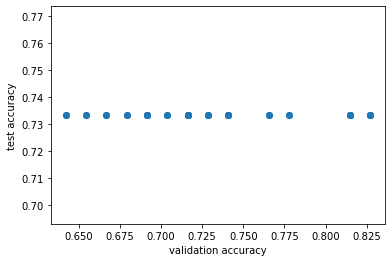

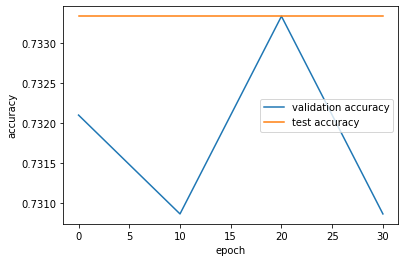

In [22]:
# 10-fold coross validation 
# factory model


import tensorflow as tf
import matplotlib.pyplot as plt
import random 


K = 10

#(x_train,y_train,x_test,y_test) = gen_data_array_cv(K)

H = 20
E = 40
es = 10

best_v = 0
best_t = 0

ValA = []
TestA = []
ValAS = [0 for x in range(0,E,es)]
TestAS = [0 for x in range(0,E,es)]
X = [x for x in range(0,E,es)]

for k in range(K):
    print ("k=",k)
    N = x_train[k].shape[0]
    M = x_train[k].shape[1]
    C = y_train[k].shape[1]

    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(H, input_shape=(M,), activation='relu'),
      tf.keras.layers.Dense(C)
    ])

    model.compile(optimizer='adam',
                  loss=loss_fn,
                  metrics=['CategoricalAccuracy'])

    #print (model.summary())
    #print (x_val[k].shape,y_val[k].shape,)
    #loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    for e in range(int(E/es)):
        model.fit(x_train[k], y_train[k], validation_data=(x_val[k],y_val[k]), epochs=es,verbose = 0)
        #model.fit(x_train[k], y_train[k],  epochs=es,verbose = 0)
        res_test = model.evaluate(x_test,  y_test, verbose=0)
        res_val = model.evaluate(x_val[k],  y_val[k], verbose=0)
        print (res_val[1], res_test[1])
        ValA.append(res_val[1])
        TestA.append(res_test[1])
        ValAS[e] += res_val[1]/K
        TestAS[e] += res_test[1]/K
        if res_val[1] > best_v:
            best_v = res_val[1]
            best_t = res_test[1]
            print ('X', res_val, res_test)
            
print ("acc=", best_t, "(",best_v,")" )

plt.scatter(ValA,TestA)
#plt.xlim([0,1])
#plt.ylim([0,1])
plt.xlabel("validation accuracy")
plt.ylabel("test accuracy")
plt.show()
plt.plot(X,ValAS,label="validation accuracy")
plt.plot(X,TestAS,label="test accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()



In [72]:
import statistics
x = [73,73,73,]
print (sum(x)/len(x),statistics.stdev(x))

83.10000000000001 0.6000000000000014


In [102]:
# read benchmark data

from pandas import  read_csv
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras

tf.enable_eager_execution()


def gen_data_array_cv2(K):
    
    fnev = "pima-indians-diabetes.csv"
    
    dataT = read_csv (fnev, header =None)
    
    dataA = np.array(dataT)    
        
    N = dataA.shape[0]
    print ("Data",dataA.shape)
    M = dataA.shape[1]-1

    Nte = int(0.1*N)
    Ntr = N - Nte

    cval = dict()
    for i in range(N):
        cval[dataA[i][-1]] = 1
    C = len(cval.keys())
    
    minv = [0 for _ in range(M)]
    maxv = [0 for _ in range(M)]
    
    for j in range(M):
        minv[j] =  dataA[0,j]
        maxv[j] =  dataA[0,j]
        
    for i in range(N):
        for j in range(M):
            minv[j] = min( dataA[i,j] , minv[j])
            maxv[j] = max( dataA[i,j] , maxv[j])
          
    orders = random.sample(range(N), N)
    print ("C=",C,"M=",M)
    x2_test = np.zeros((Nte,M),dtype='float32')
    y2_test = np.zeros((Nte,C))
    print ("test",x2_test.shape, y2_test.shape)
    
    ite = 0
    for n in range(Ntr, N):
        i = orders[n]
        for j in range(M):
            x2_test[ite,j] = (dataA[i,j] - minv[j]) / (maxv[j] - minv[j])
            y2_test[ite, int(dataA[i,M])] = 1
        ite += 1    
       
    if K == 1:
        Ntrv = 0
        Ntrt = Ntr 

        x2_train = []
        y2_train = []
        x2_val = []
        y2_val = []
        x2A_val = []
        y2A_val = []

        x2_train.append(np.zeros((Ntrt,M),dtype='float32'))
        y2_train.append(np.zeros((Ntrt,C)))
        k = 0
        itr = 0
        ite = 0
        for n in range(Ntr):
            i = orders[n]
            for j in range(M):
                x2_train[k][itr,j] = (dataA[i,j] - minv[j]) / (maxv[j] - minv[j])
            y2_train[k][itr,int(dataA[i,M])] = 1
            itr += 1
        
        
    else:
        Ntrv = int(Ntr/K)
        Ntrt = Ntr - Ntrv

        x2_train = []
        y2_train = []
        x2_val = []
        y2_val = []
        x2A_val = []
        y2A_val = []

    
        Ntrv2 = min(3*Ntrv, Ntrt)
        print (Ntr, Nte, Ntrt, Ntrv, Ntrv2)
        for k in range(K):
            #print (k," ----------- ")
            #print (Ntrt, Ntrv, Ntrv2)
            x2_train.append(np.zeros((Ntrt,M),dtype='float32'))
            y2_train.append(np.zeros((Ntrt,C)))
            x2_val.append(np.zeros((Ntrv2,M),dtype='float32'))
            y2_val.append(np.zeros((Ntrv2,C)))
            x2A_val.append(np.zeros((Ntrv,M),dtype='float32'))
            y2A_val.append(np.zeros((Ntrv,C)))

            #print ("x2_val", x2_val[k].shape)
            itr = 0
            ite = 0
            for n in range(Ntr):
                i = orders[n]
                if n >= k*Ntrv and n < (k+1)*Ntrv:
                    for j in range(M):
                        x2_val[k][ite,j] = (dataA[i,j] - minv[j]) / (maxv[j] - minv[j])
                        x2A_val[k][ite,j] = (dataA[i,j] - minv[j]) / (maxv[j] - minv[j])
                        y2_val[k][ite, int(dataA[i,M])] = 1
                    y2A_val[k][ite, int(dataA[i,M])] = 1
                    ite += 1
                else:            
                    for j in range(M):
                        x2_train[k][itr,j] = (dataA[i,j] - minv[j]) / (maxv[j] - minv[j])
                    y2_train[k][itr,int(dataA[i,M])] = 1
                    itr += 1
                
            extra = random.sample(range(Ntrt),Ntrv2)
            ite = Ntrv
            for n in range(Ntrv2 - Ntrv):
                i = extra[n]
                for j in range(M):
                    x2_val[k][ite,j] = x2_train[k][i,j]
                pos = list(y2_train[k][i,:]).index(1)
                #print (y2_train[k][i,:],pos)
                y2_val[k][ite, pos] = 1
                ite += 1
                
                
    return (x2_train,y2_train, x2A_val, y2A_val, x2_val, y2_val, x2_test, y2_test)

K = 5
(x_train,y_train,xA_val, yA_val, x_val,y_val, x_test,y_test) = gen_data_array_cv2(K)


Data (306, 4)
C= 2 M= 3
(30, 3) (30, 2)
[49 63  0  2] 0 114 2
[44 63 19  2] 1 75 2
[34 66  9  2] 5 8 2
[53 63 24  2] 10 160 2
[43 58 52  2] 19 62 2
[46 62  5  2] 20 91 2
[47 62  0  2] 21 97 2
[55 68 15  2] 27 181 2
276 30 221 55 165
[41 60 23  2]


IndexError: index 2 is out of bounds for axis 1 with size 2

In [10]:
# read benchmark data

from pandas import  read_csv
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras

tf.enable_eager_execution()


def gen_data_array_cv2(K):
    

    fnev = "haberman.csv"
    
    dataT = read_csv (fnev, header =None)
    
    dataA = np.array(dataT)    
        
    N = dataA.shape[0]
    print ("Data",dataA.shape)
    M = dataA.shape[1]-1

    Nte = int(0.1*N)
    Ntr = N - Nte

    cval = dict()
    for i in range(N):
        cval[dataA[i][-1]] = 1
    C = len(cval.keys())
    
    minv = [0 for _ in range(M)]
    maxv = [0 for _ in range(M)]
    
    for j in range(M):
        minv[j] =  dataA[0,j]
        maxv[j] =  dataA[0,j]
        
    for i in range(N):
        for j in range(M):
            minv[j] = min( dataA[i,j] , minv[j])
            maxv[j] = max( dataA[i,j] , maxv[j])
          
    orders = random.sample(range(N), N)
    print ("C=",C,"M=",M)
    x2_test = np.zeros((Nte,M),dtype='float32')
    y2_test = np.zeros((Nte,C))
    print ("test",x2_test.shape, y2_test.shape)
    
    ite = 0
    for n in range(Ntr, N):
        i = orders[n]
        for j in range(M):
            x2_test[ite,j] = (dataA[i,j] - minv[j]) / (maxv[j] - minv[j])
            y2_test[ite, int(dataA[i,M])-1] = 1
        ite += 1    
       
    if K == 1:
        Ntrv = 0
        Ntrt = Ntr 

        x2_train = []
        y2_train = []
        x2_val = []
        y2_val = []
        x2A_val = []
        y2A_val = []

        x2_train.append(np.zeros((Ntrt,M),dtype='float32'))
        y2_train.append(np.zeros((Ntrt,C)))
        k = 0
        itr = 0
        ite = 0
        for n in range(Ntr):
            i = orders[n]
            for j in range(M):
                x2_train[k][itr,j] = (dataA[i,j] - minv[j]) / (maxv[j] - minv[j])
            y2_train[k][itr,int(dataA[i,M])-1] = 1
            itr += 1
        
        
    else:
        Ntrv = int(Ntr/K)
        Ntrt = Ntr - Ntrv

        x2_train = []
        y2_train = []
        x2_val = []
        y2_val = []
        x2A_val = []
        y2A_val = []

    
        Ntrv2 = min(3*Ntrv, Ntrt)
        print (Ntr, Nte, Ntrt, Ntrv, Ntrv2)
        for k in range(K):
            #print (k," ----------- ")
            #print (Ntrt, Ntrv, Ntrv2)
            x2_train.append(np.zeros((Ntrt,M),dtype='float32'))
            y2_train.append(np.zeros((Ntrt,C)))
            x2_val.append(np.zeros((Ntrv2,M),dtype='float32'))
            y2_val.append(np.zeros((Ntrv2,C)))
            x2A_val.append(np.zeros((Ntrv,M),dtype='float32'))
            y2A_val.append(np.zeros((Ntrv,C)))

            #print ("x2_val", x2_val[k].shape)
            itr = 0
            ite = 0
            for n in range(Ntr):
                i = orders[n]
                if n >= k*Ntrv and n < (k+1)*Ntrv:
                    for j in range(M):
                        x2_val[k][ite,j] = (dataA[i,j] - minv[j]) / (maxv[j] - minv[j])
                        x2A_val[k][ite,j] = (dataA[i,j] - minv[j]) / (maxv[j] - minv[j])
                        y2_val[k][ite, int(dataA[i,M])-1] = 1
                    y2A_val[k][ite, int(dataA[i,M])-1] = 1
                    ite += 1
                else:            
                    for j in range(M):
                        x2_train[k][itr,j] = (dataA[i,j] - minv[j]) / (maxv[j] - minv[j])
                    y2_train[k][itr,int(dataA[i,M])-1] = 1
                    itr += 1
                
            extra = random.sample(range(Ntrt),Ntrv2)
            ite = Ntrv
            for n in range(Ntrv2 - Ntrv):
                i = extra[n]
                for j in range(M):
                    x2_val[k][ite,j] = x2_train[k][i,j]
                pos = list(y2_train[k][i,:]).index(1)
                #print (y2_train[k][i,:],pos)
                y2_val[k][ite, pos] = 1
                ite += 1
                
                
    return (x2_train,y2_train, x2A_val, y2A_val, x2_val, y2_val, x2_test, y2_test)

K = 10
(x_train,y_train,xA_val, yA_val, x_val,y_val, x_test,y_test) = gen_data_array_cv2(K)


Data (306, 4)
C= 2 M= 3
test (30, 3) (30, 2)
276 30 249 27 81


In [24]:
print (y_test)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
